In [13]:
import re
import pandas as pd
import numpy as np
import datetime

In [14]:
def parser(file):
    #Initialize list
    lines = []
    
    #Open File
    with open(file, 'r') as file:
        for line in file:
            lines.append(line.rstrip('\n'))

    #Extract Date
    Date = (re.split('[\s]{4,}', lines[1].strip()))
    Date = Date[0]
    Date = Date.replace('Run Date: ', '')

    #Extract indices to cut list
    indices = [i for i, s in enumerate(lines) if '-----' in s]
    indicest = [i for i, s in enumerate(lines) if 'TOTAL' in s]

    #Create list with only well licenses
    df1 = lines[(indices[0]+1):(indicest[0]-1)]

    dfsplit = lines[indices[0]]

    def find(s, ch):
        return [i for i, ltr in enumerate(s) if ltr == ch]

    cut = find(dfsplit,' ')

    df2 = []
    for line in df1:
        df2.append(line[0:cut[0]])
        df2.append(line[cut[0]:cut[1]])
        df2.append(line[cut[1]:cut[2]])
        df2.append(line[cut[2]:cut[3]])
        df2.append(line[cut[3]:cut[4]])
        df2.append(line[cut[4]:cut[5]])
        df2.append(line[cut[5]:cut[6]])
        df2.append(line[cut[6]:cut[7]])
        df2.append(line[cut[7]::])

    #Create a list without all spaces
    df3 = []
    for line in df2:
        df3.extend(re.split('[\s]{5,}', line.strip()))

    df3 = [df3[x:x+9] for x in range(0, len(df3), 9)]
    df3

    #create a dataframe out of the list
    if df3 != []:
        data1 = pd.DataFrame(df3)
        data1.set_axis(['BA ID', 'LICENSEE', 'LICENCE', 'FIELD CENTRE', 'ACTIVITY START DATE', 'PIPELINE LINE NUMBER', 'FROM', 'TO', 'LENGTH'], axis = 1, inplace=True)
        data1['DATE'] = Date

        return data1

In [15]:
import os

from pathlib import Path

directory_in_str = "/Users/jjayaro/Documents/AER CSVs/ST100"

directory = os.fsencode(directory_in_str) 

columns = ['BA ID', 'LICENSEE', 'LICENCE', 'FIELD CENTRE', 'ACTIVITY START DATE', 'PIPELINE LINE NUMBER', 'FROM', 'TO', 'LENGTH']

df = pd.DataFrame(columns=columns)

ext = ['.txt','.TXT']

for file in os.listdir(directory): 
    filename = os.fsdecode(file) 
    if filename.endswith('.txt'): 
        data = parser(os.path.join(directory_in_str, filename))
        df = df.append(data, ignore_index=True, sort=False)
        continue 
    else: 
        continue

In [16]:
df

,BA ID,LICENSEE,LICENCE,FIELD CENTRE,ACTIVITY START DATE,PIPELINE LINE NUMBER,FROM,TO,LENGTH,DATE
0,A77W,Artis Exploration Ltd.,59004,Red Deer,06 Jan 2020 07:01:00 AM,23,03-22-031-25W4,03-26-031-25W4,2.73,02 Jan 2020
1,A77W,Artis Exploration Ltd.,60348,Red Deer,06 Jan 2020 07:01:00 AM,4,03-22-031-25W4,03-26-031-25W4,2.73,02 Jan 2020
2,0HE9,Canadian Natural Resources Limited,58704,Medicine Hat,03 Jan 2020 09:01:00 AM,422,04-30-007-16W4,04-30-007-16W4,0.37,02 Jan 2020
3,A76W,Longshore Resources Ltd.,59684,Grande Prairie,04 Jan 2020 12:01:00 PM,4,05-15-077-10W6,12-15-077-10W6,0.31,02 Jan 2020
4,A0A7,NuVista Energy Ltd.,51413,Grande Prairie,03 Jan 2020 08:01:00 AM,99,08-26-068-07W6,15-36-068-08W6,2.61,02 Jan 2020
...,...,...,...,...,...,...,...,...,...,...
696,A789,Anegada Oil Corp.,60940,Grande Prairie,15 Oct 2020 07:10:00 AM,6,09-28-071-08W6,14-34-071-08W6,2.76,14 Oct 2020
697,A789,Anegada Oil Corp.,60940,Grande Prairie,16 Oct 2020 07:10:00 AM,7,14-34-071-08W6,11-14-072-08W6,5.54,15 Oct 2020
698,A789,Anegada Oil Corp.,60940,Grande Prairie,16 Oct 2020 07:10:00 AM,8,02-15-072-08W6,11-14-072-08W6,1.75,15 Oct 2020
699,0BP8,Obsidian Energy Ltd.,58303,Slave Lake,19 Oct 2020 08:10:00 AM,6,13-18-082-17W5,14-18-082-17W5,0.28,15 Oct 2020


In [5]:
datac = df

#Conversion of Surface Location to numbers only in order to search ATS values and match them to latitude and longitude
datac['ATS-FROM'] = datac['FROM'].str.replace(r'[^0-9]+', '')
datac['ATS-TO'] = datac['TO'].str.replace(r'[^0-9]+', '')
datac['ATS-FROM'] = datac['ATS-FROM'].str[-8:]
datac['ATS-TO'] = datac['ATS-TO'].str[-8:]

nan_value = float("NaN")
datac.replace("", nan_value, inplace=True)
datac.dropna(subset = ["ATS-FROM"], inplace=True)

#Conversion to integers
datac['ATS-FROM'] = datac['ATS-FROM'].astype('int64')
datac['ATS-TO'] = datac['ATS-TO'].astype('int64')


In [6]:
#Conversion to Lat/Long
convcomp = pd.read_csv('ConvComp.csv')
convcomp['ConvDF'] = convcomp['ConvDF'].astype('int64')
dfm = pd.merge(datac, convcomp, how='left', left_on='ATS-FROM', right_on='ConvDF')
dfm2 = pd.merge(dfm, convcomp, how='left', left_on='ATS-TO', right_on='ConvDF')

dfm2

#datac['DATE'] = datac['DATE'].astype('datetime64')
#datac['WEEK'] = datac['DATE'].dt.week
#datac['MONTH'] = datac['DATE'].dt.month
#datac['YEAR'] = datac['DATE'].dt.year

,BA ID,LICENSEE,LICENCE,FIELD CENTRE,ACTIVITY START DATE,PIPELINE LINE NUMBER,FROM,TO,LENGTH,DATE,ATS-FROM,ATS-TO,ConvDF_x,Lat_x,Long_x,ConvDF_y,Lat_y,Long_y
0,A5RX,Bonavista Energy Corporation,27916,Red Deer,21 Jan 2020 07:01:00 AM,21,04-01-041-07W5,02-01-041-07W5,0.89,19 Jan 2020,1041075,1041075,1041075,52.501404,-114.865310,1041075.0,52.501404,-114.865310
1,A789,Anegada Oil Corp.,60031,Grande Prairie,10 Jan 2020 08:01:00 AM,5,01-14-072-08W6,11-14-072-08W6,1.53,08 Jan 2020,14072086,14072086,14072086,55.236087,-119.102827,14072086.0,55.236087,-119.102827
2,A789,Anegada Oil Corp.,60940,Grande Prairie,10 Jan 2020 08:01:00 AM,5,11-14-072-08W6,01-14-072-08W6,1.52,08 Jan 2020,14072086,14072086,14072086,55.236087,-119.102827,14072086.0,55.236087,-119.102827
3,A6JK,InPlay Oil Corp.,61478,Drayton Valley,10 Jan 2020 08:01:00 AM,1,09-26-049-07W5,01-26-049-07W5,0.8,08 Jan 2020,26049075,26049075,26049075,53.257935,-114.903788,26049075.0,53.257935,-114.903788
4,A6JK,InPlay Oil Corp.,61478,Drayton Valley,10 Jan 2020 08:01:00 AM,2,09-26-049-07W5,01-26-049-07W5,0.8,08 Jan 2020,26049075,26049075,26049075,53.257935,-114.903788,26049075.0,53.257935,-114.903788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,A267,Secure Energy Services Inc.,61573,Edmonton,05 Mar 2020 08:03:00 AM,1,01-33-060-19W5,06-35-060-20W5,8.62,03 Mar 2020,33060195,35060205,33060195,54.232235,-116.776559,35060205.0,54.232211,-116.876522
528,A6FW,Vermilion Energy Inc.,52083,Drayton Valley,05 Mar 2020 07:03:00 AM,113,12-16-049-12W5,09-16-049-12W5,1.18,03 Mar 2020,16049125,16049125,16049125,53.228839,-115.683884,16049125.0,53.228839,-115.683884
529,A6FW,Vermilion Energy Inc.,52083,Drayton Valley,05 Mar 2020 07:03:00 AM,114,12-16-049-12W5,09-16-049-12W5,1.18,03 Mar 2020,16049125,16049125,16049125,53.228839,-115.683884,16049125.0,53.228839,-115.683884
530,A6JK,InPlay Oil Corp.,48477,Drayton Valley,28 Mar 2020 08:03:00 AM,3,10-28-048-08W5,10-28-048-08W5,0.1,27 Mar 2020,28048085,28048085,28048085,53.170637,-115.098752,28048085.0,53.170637,-115.098752


In [7]:
#Export to CSV
dfm2.to_csv(r'ST100.csv', index = False)

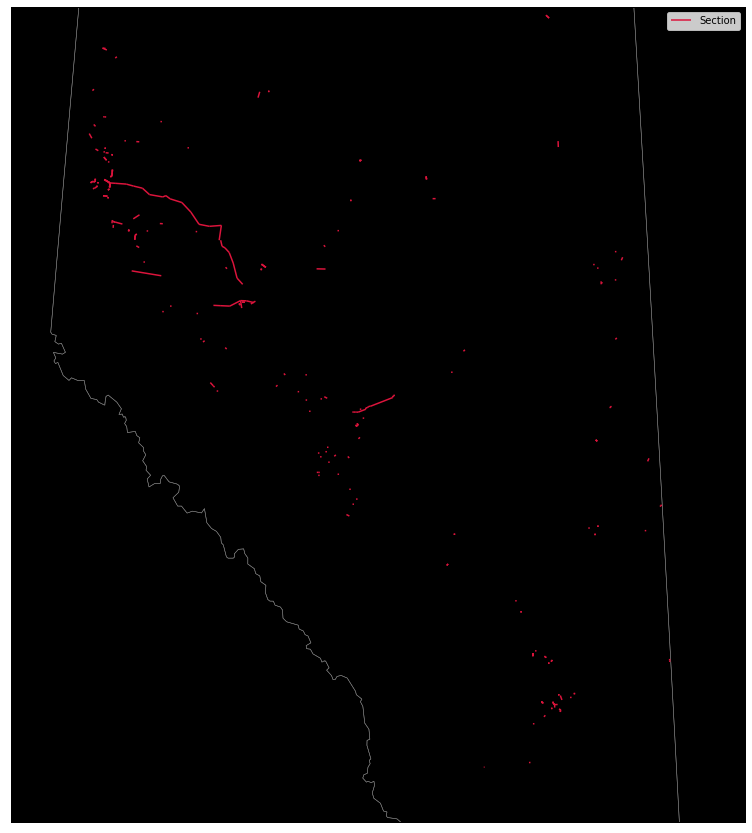

In [8]:
import numpy as np; np.random.seed(42)
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(15,15))

m = Basemap(llcrnrlon=-120,llcrnrlat=49,urcrnrlon=-108, urcrnrlat=57,
             resolution='i', projection='cass', lat_0 = 51, lon_0 = -114)

#m.drawcoastlines(linewidth=0.72, color='gray')
#m.drawcountries(zorder=0, color='gray')
#m.bluemarble()
m.drawmapboundary(fill_color='black')
m.drawstates(color='grey')

Long_x, Lat_x = m(dfm2.Long_x.values, dfm2.Lat_x.values)
Long_y, Lat_y = m(dfm2.Long_y.values, dfm2.Lat_y.values)

pts = np.c_[Long_x, Lat_x, Long_y, Lat_y].reshape(len(Long_x), 2, 2)
plt.gca().add_collection(LineCollection(pts, color="crimson", label="Section"))

m.plot(Long_x, Lat_x, ls="")
m.plot(Long_y, Lat_y, ls="")

plt.legend()
plt.savefig('ST100.png')

